In [1]:
import numpy as np
import pyvibdmc as pv
import matplotlib.pyplot as plt
import h5py

In [2]:
path_to_data = 'C:/Users/gjaco/OneDrive/Documents/UW/McCoy Group/H5O3-/Data/NN_Data/360_3hidden_0_decay_0_dropout_double_sort/1.0w_50000_walkers_50000t_1dt' #path to the folder containing the simulation data

For this example notebook, we'll play with the system I call "H5O3", and the order of the atoms in the simulation is O, H, O, H, H, O, H, H. This simulation propagated 50,000 walkers for 50,000 timesteps.

Below is the code for loading in the simulation data using PyVibDMC's built-in functions

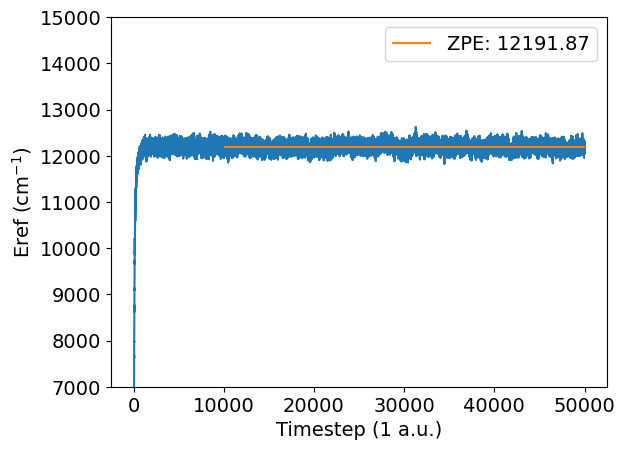

In [3]:
sim_data = pv.SimInfo(f'{path_to_data}/H5O3_0_sim_info.hdf5') #name of the simulation summary file

#ZPE = tutorial_sim.get_zpe(onwards=15000, ret_cm=True)

start = 10000 #where we want to start averaging the energy from
stop = 50000 #where we want to average until

vref = sim_data.get_vref(ret_cm=True) #generates an array of the timesteps and the average energy of the ensemble at that step
ZPE = np.mean(vref[start:stop][:,1]) #calculate the average energy in the relevant range of time steps (while the energy is stable)

plt.plot(vref[:,0],vref[:,1])
plt.hlines(y= ZPE,xmin = start,xmax= stop, color = 'tab:orange', label='ZPE: {0:.2f}'.format(ZPE))
plt.legend()

plt.ylabel('Eref (cm$^{-1}$)')
plt.xlabel('Timestep (1 a.u.)')
plt.ylim(7000,15000)

plt.show()

Now that we can verify the energy is stable and the simulation is well-converged from timesteps 10,000 to 50,000, we can pull the structures from the simulations across all those timesteps to get statistics on the ground state wave function.

In [4]:
snapshots = np.arange(10000,50000,1000) #pull data every 1000 time steps from 10,000 to 50,000

sim_data = pv.SimInfo(f'{path_to_data}/H5O3_0_sim_info.hdf5') #name of the simulation summary file
coords, weights = sim_data.get_wfns(snapshots) #load in the molecule geometries (coords) and their associated weights
coords = pv.Constants.convert(coords,'angstroms',to_AU=False) # conversion of coordinates from atomic units to Angstroms (more common in chemistry)

PyVibDMC has functions for calculating bond lengths and bond angles, so we can calculate these quantities across the whole ensemble of molecules and then plot the distributions of these coordinates

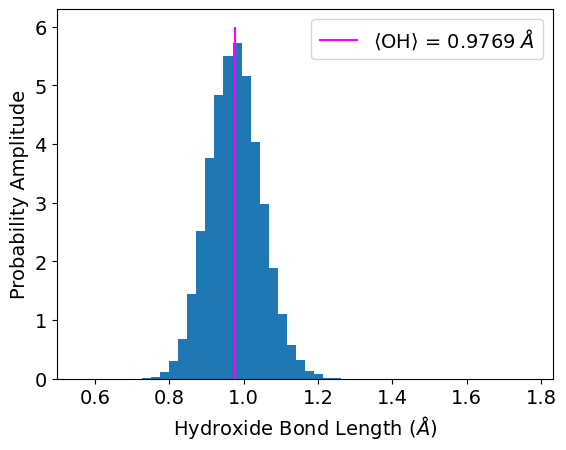

In [5]:
analyzer = pv.AnalyzeWfn(coords)

hydroxide_distance = analyzer.bond_length(0,1) #calculates the distance between the first two atoms in the coordinates array, which correspond to the hydroxide ion

exp_val = analyzer.exp_val(hydroxide_distance,weights) #calculates the expectation value (average) of the quantity

#plot a histogram of all the values in the ensemble
plt.hist(hydroxide_distance, bins=50, weights = weights, density=True) #normalizes the distribution so the total probability is 1

#plot a vertical line where the average value is
plt.vlines(exp_val,0,6,color = 'magenta',label=rf'$\langle$OH$\rangle$ = {exp_val:.4f} $\AA$')

plt.legend()
plt.xlabel('Hydroxide Bond Length ($\AA$)')
plt.ylabel('Probability Amplitude')
plt.show() #basic histogramm kind of ugly

Sometimes it's easier to convert the histogram to a single line plot that connects the dots between the bin values, especially when we want to plot more than one distribution on top of each other

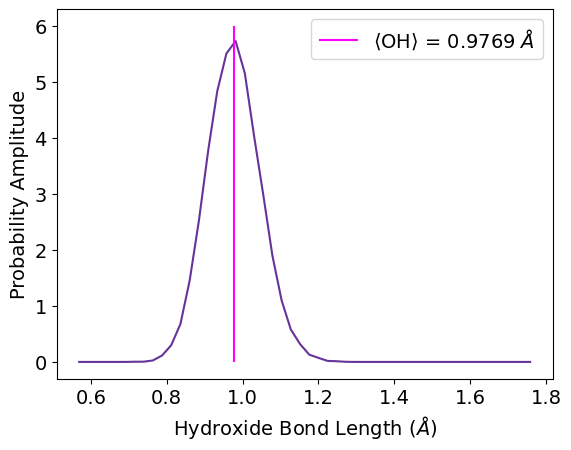

In [6]:
n, bins = np.histogram(hydroxide_distance,bins=50,weights=weights,density=True)

bin_centers = (bins[:-1] + bins[1:]) / 2

plt.plot(bin_centers,n,color='rebeccapurple')

#plot a vertical line where the average value is
plt.vlines(exp_val,0,6,color = 'magenta',label=rf'$\langle$OH$\rangle$ = {exp_val:.4f} $\AA$')

plt.legend()
plt.xlabel('Hydroxide Bond Length ($\AA$)')
plt.ylabel('Probability Amplitude')
plt.show()

Let's try plotting all the different OH distances on top of each other

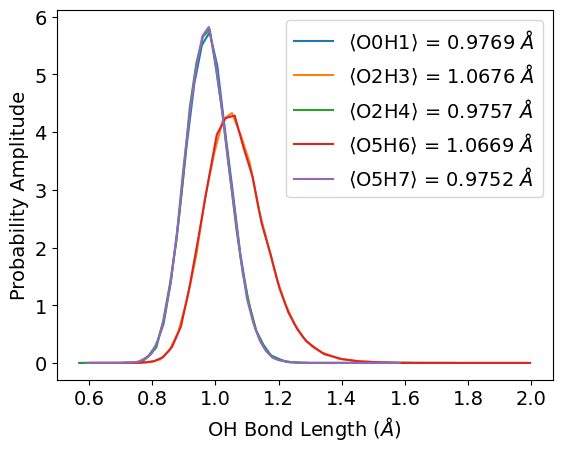

In [7]:
OHs = [[0,1],[2,3],[2,4],[5,6],[5,7]]

for dist in range(len(OHs)):
    oh_distance = analyzer.bond_length(OHs[dist][0],OHs[dist][1])
    exp_val = analyzer.exp_val(oh_distance,weights) #calculates the expectation value (average) of the quantity

    n, bins = np.histogram(oh_distance,bins=50,weights=weights,density=True)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.plot(bin_centers,n,label=rf'$\langle$O{OHs[dist][0]}H{OHs[dist][1]}$\rangle$ = {exp_val:.4f} $\AA$')
    plt.legend()

plt.legend()
plt.xlabel('OH Bond Length ($\AA$)')
plt.ylabel('Probability Amplitude')
plt.show()

Next, we can see if any of these geometries are correlated by making a 2D histogram or contour plot between 2 of the quantities.

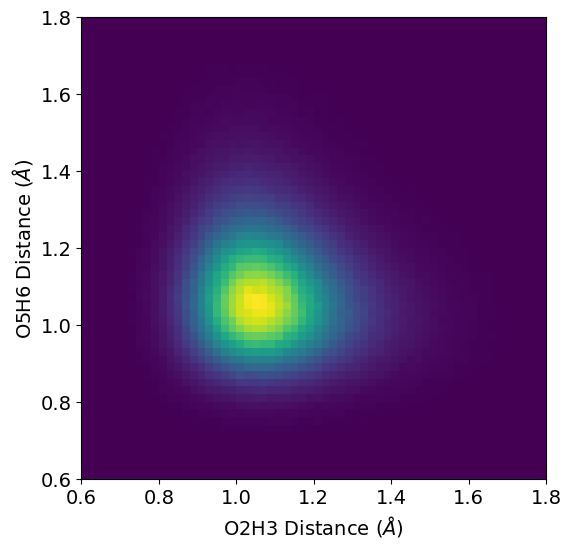

In [8]:
#lets look at the two of the OH distances in the molecule that I already know will be correlated :)

plt.figure(figsize=(6,6))

OH_1 = analyzer.bond_length(2,3)
OH_2 = analyzer.bond_length(5,6)

plt.hist2d(OH_1,OH_2,bins=[np.arange(0.6,1.8,0.02),np.arange(0.6,1.8,0.02)])
plt.xlabel('O2H3 Distance ($\AA$)')
plt.ylabel('O5H6 Distance ($\AA$)')
plt.show()

#hard to see but since this plot isn't perfectly circular, there's some correlation between these two quantities
#for example, as one distance gets longer, there's a greater probability that the other will get shorter

For my own research in training neural net models on this data, I also like to look at the full distribution of molecular energies in the simulation

In [9]:
training_snaps = np.arange(0,50000,1000)
energies_list = []

for i in training_snaps:
    cds,energies = sim_data.get_training(f'{path_to_data}/H5O3_0_training_{i}ts.hdf5',ret_ang=False, ret_cm=True) #return the energies in cm-1
    
    energies_list.append(energies)
    
energies_array = np.concatenate(energies_list)

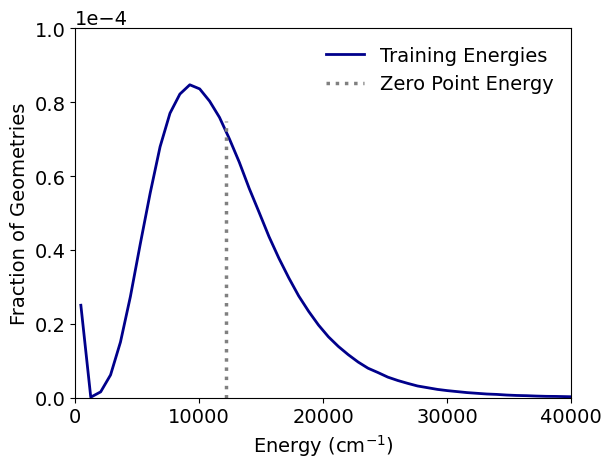

In [10]:
n, bins = np.histogram(energies_array,bins=150,weights=None,density=True)
bin_centers = (bins[:-1] + bins[1:]) / 2
plt.plot(bin_centers, n,linewidth = 2,label='Training Energies',color='darkblue')

plt.vlines(ZPE,0,0.000075,linestyle='dotted',color='gray',label='Zero Point Energy',linewidth=2.5)

plt.xlim(0,40000)
plt.xticks(ticks =[0,10000,20000,30000,40000], labels=[0,10000,20000,30000,40000])
plt.ylim(0,1e-4)
# Format y-axis labels in scientific notation
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend(frameon=False,fontsize=14)
plt.xlabel('Energy (cm$^{-1}$)',fontsize=14)
plt.ylabel('Fraction of Geometries',fontsize=14)
plt.show()

Here I can compare the relative distribution of energies in all my simulation data, as it relates to our determined zero point energy for the system. There's a blip right at 0 because I start my all my walkers at the minimum energy structure at the start of the simulation, and then I collected all those energies right away. If you want to just look at the energies after the simulation reaches equilibration, try changing the "training_snaps" range to start at something like 10,000